

# DarkSide-50

##### Author: Ilyasov A., Kurchatov Institute, Russian Federation

<div class="alert alert-block alert-info">
<b>Our plan:</b> We want to improve our analysis in the ROI and expand the left boundary of energies <b> using MC data </b>
    
<b>Наша цель:</b> Мы хотим улучшить анализ в области низких энергий <b> используя данные Монте Карло моделирования </b>
</div>

## Import necessary libraries and define some functions
## Подключение необходимых библиотек и определение некоторых функций

In [1]:
from sklearn import ensemble, metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
from scipy import stats, optimize
from scipy.stats import t
from scipy.stats.kde import gaussian_kde
from IPython.display import Image
from pylab import *
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
import pylab
import sys
import itertools
import uproot
import math
import pickle
import cellbell
# cellbell.ding()
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Reading data from .csv file and preparing dataset
## Чтение данных с .csv файлов и подготовка данных

In [2]:
df_Ar39 = pd.read_csv('./Ar39_38param.csv',header = 0, sep = ",")

In [3]:
df_Ar40 = pd.read_csv('./Ar40_38param.csv',header = 0, sep = ",")

In [6]:
df_Ar40_sample = df_Ar40.sample(len(df_Ar39))

In [7]:
frames = [df_Ar40_sample, df_Ar39]
ds = pd.concat(frames)

In [9]:
ds_target = ds.type.values
ds_data = ds.iloc[:,1:-2]

#### Plot correlation matrix
#### Построение корреляционной матрицы

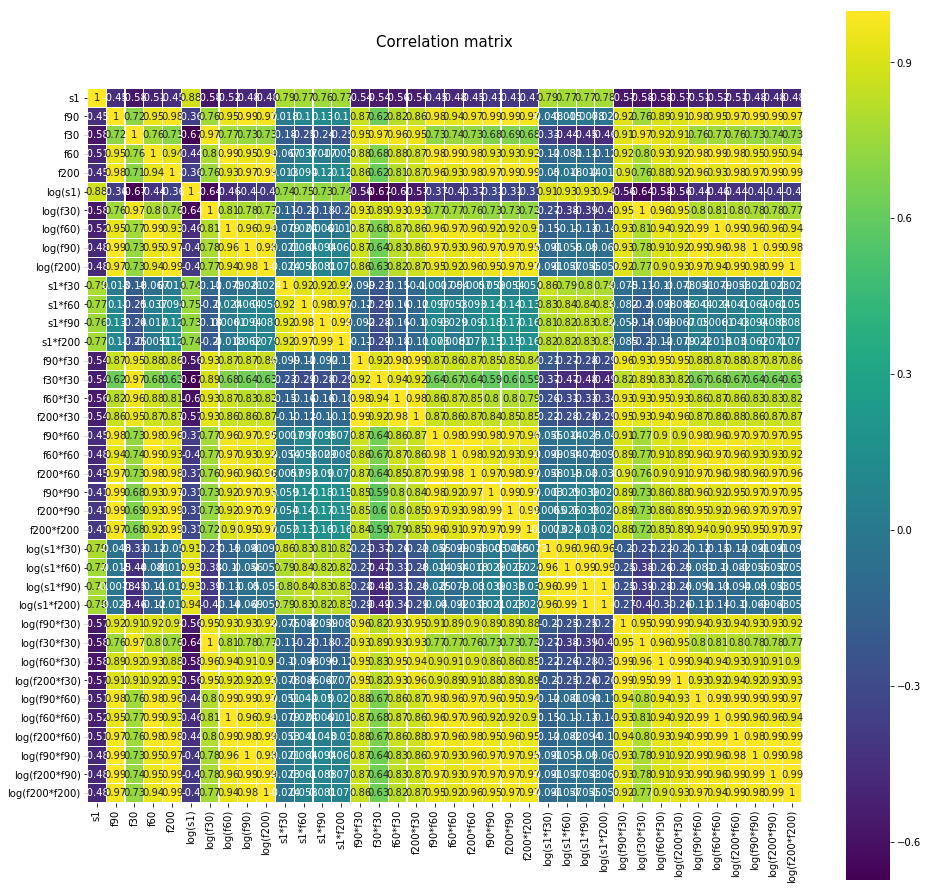

In [11]:
colormap = plt.cm.viridis
plt.figure(figsize=(16,16))
plt.title('Correlation matrix', y=1.05, size=15)
sns.heatmap(ds_data.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## XGBoost classifier
## Классификатор XGBoost

In [12]:
# Divide data on train and test
# Разделение данных на тренировочный и тестовый набор
seed = 3
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(ds_data, ds_target, test_size = test_size, random_state = seed)

In [15]:
# Choosing the model and train it with standart parameters
# Задаем модель и тренируем ее со стандартными параметрами
xgbmodel = xgb.XGBClassifier()

xgbmodel.fit(X_train, Y_train)

In [ ]:
# Saving the model
# Сохранение модели
pkl_filename = "xgboost_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgbmodel, file)

In [17]:
# Calculation of classification report
# Вычисление эффективности классификатора
xgb_pred = xgbmodel.predict(X_test)
print(classification_report(Y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    183250
           1       1.00      1.00      1.00    182967

    accuracy                           1.00    366217
   macro avg       1.00      1.00      1.00    366217
weighted avg       1.00      1.00      1.00    366217



In [ ]:
# Calculation BRR and SA for ROC-curve
# Вычисление аксептанса сигнала и режекции фона для построения ROC-кривой
predictions_xgb = xgbmodel.predict_proba(X_test)
preds_xgb = predictions_xgb[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(Y_test, preds_xgb)
backrej_xgb=np.abs(fpr_xgb-1)

### Graphical analysis
### Графический анализ

XGBoost


Text(0, 0.5, 'Переменная')

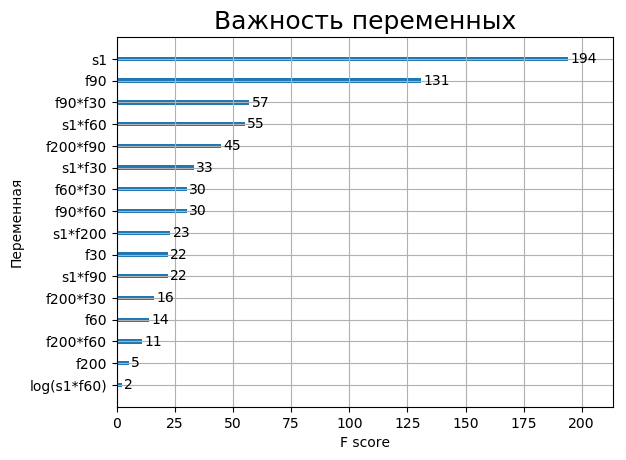

In [19]:
# Plotting feature importance
# Построение гистограммы важности переменных
plt.rcdefaults()
plot_importance(xgbmodel, grid = True, max_num_features = 30)
print ("XGBoost")
plt.title('Важность переменных', fontsize=18)
plt.xlabel('F score',fontsize=10)
plt.ylabel('Переменная',fontsize=10)

Confusion matrix, without normalization
[[182521    729]
 [    47 182920]]


Text(71.92222222222235, 0.5, 'Истинная метка класса')

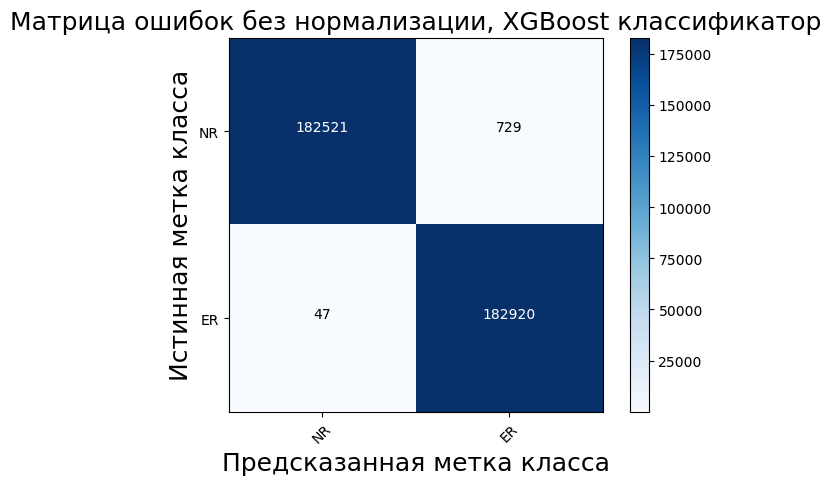

In [20]:
# Plotting confusion matrix
# Построение матрицы ошибок
cnf_matrix_xgb_gs = confusion_matrix(Y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_xgb_gs,  classes=["NR","ER"],
                      title='Матрица ошибок без нормализации, XGBoost классификатор')
plt.title('Матрица ошибок без нормализации, XGBoost классификатор', fontsize=18)
plt.xlabel('Предсказанная метка класса',fontsize=18)
plt.ylabel('Истинная метка класса',fontsize=18)

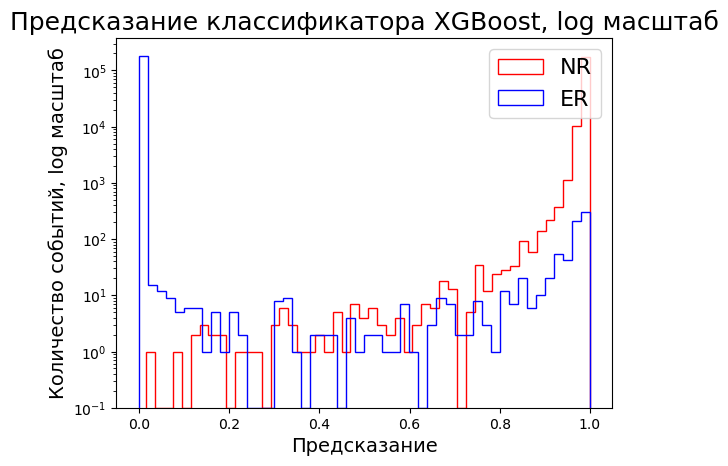

In [24]:
# Plotting predictions of the model, log-scale
# Построение предсказания модели, логарифмический масштаб
idx_NR_xgb = np.where(Y_test == 1)[0]
idx_ER_xgb = np.where(Y_test == 0)[0]
bins = 50
n1_xgb, bins1_xgb, patches1_xgb = plt.hist(predictions_xgb[idx_NR_xgb, 1], log = True, histtype='step', label='NR', bins = bins, color = 'red')
n2_xgb, bins2_xgb, patches2_xgb = plt.hist(predictions_xgb[idx_ER_xgb, 1], log = True, histtype='step', label='ER', bins = bins, color = 'blue')
plt.title('Предсказание классификатора XGBoost, log масштаб', fontsize=18)
plt.xlabel('Предсказание',fontsize=14)
plt.ylabel('Количество событий, log масштаб',fontsize=14)
plt.legend(fontsize = 'large', prop={'size': 16})

### Grid Search application
### Оптимизация параметров методом поиска по сетке

In [25]:
# Set grid parameters
# Задаем сетку параметров
param_grid = [
    {
        'max_depth':[10,15],
        'min_child_weight' : [3,8,9,10]
        'gamma' : [0,0.1,0.2,0.3,0.4,0.5]
        'subsample':[0.5, 0.7, 0.9],
        'colsample_bytree':[0.8, 0.9, 1]
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
        'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
   }
]

In [ ]:
# Output the best parameters of grid
# Выводим наилучшие параметры сетки
xgbmodel_gs = GridSearchCV(xgbmodel, param_grid, cv=None, scoring='recall')
xgbmodel_gs.fit(X_train, Y_train)
print("Best parameters set found on development set:")
print(xgbmodel_gs.best_params_)

In [25]:
# Set and train new model with updated parameters
# Создаем и тренируем новую модель с обновленными параметрами
xgbmodel_gs = xgb.XGBClassifier(**xgbmodel_gs.best_params_)

xgbmodel_gs.fit(X_train, Y_train)

In [ ]:
# Saving the model after update
# Сохранение модели после обновления
pkl_filename = "xgboost_gs_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgbmodel_gs, file)

In [27]:
# Calculation of classification report after update
# Вычисление эффективности классификатора после обновления
xgb_gs_pred = xgbmodel_gs.predict(X_test)
print(classification_report(Y_test, xgb_gs_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    183250
           1       1.00      1.00      1.00    182967

    accuracy                           1.00    366217
   macro avg       1.00      1.00      1.00    366217
weighted avg       1.00      1.00      1.00    366217



In [ ]:
# Calculation BRR and SA for ROC-curve after update
# Вычисление аксептанса сигнала и режекции фона для построения ROC-кривой после обновления
predictions_xgb_gs = xgbmodel_gs.predict_proba(X_test)
preds_xgb_gs = predictions_xgb_gs[:,1]
fpr_xgb_gs, tpr_xgb_gs, thresholds_xgb_gs = metrics.roc_curve(Y_test, preds_xgb_gs)
backrej_xgb_gs=np.abs(fpr_xgb_gs-1)

### Graphical analysis after update
### Графический анализ после обновления

XGBoost


Text(0, 0.5, 'Переменная')

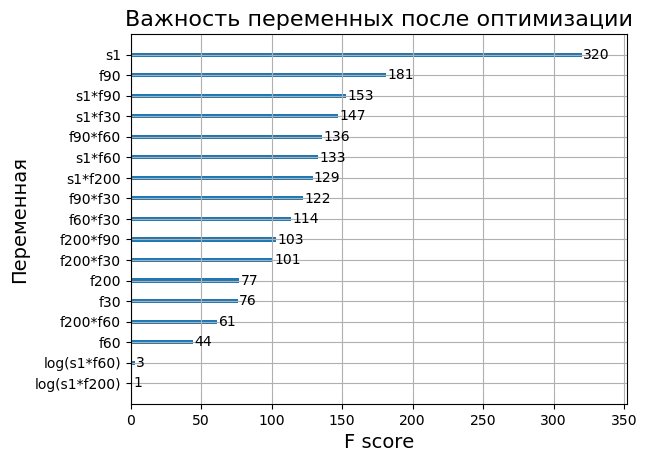

In [28]:
# Plotting feature importance after update
# Построение гистограммы важности переменных после обновления
plot_importance(xgbmodel_gs, grid = True, max_num_features = 30)
print ("XGBoost")
plt.title('Важность переменных после оптимизации', fontsize=16)
plt.xlabel('F score',fontsize=14)
plt.ylabel('Переменная',fontsize=14)

Confusion matrix, without normalization
[[182520    730]
 [    41 182926]]


Text(71.92222222222235, 0.5, 'Истинная метка класса')

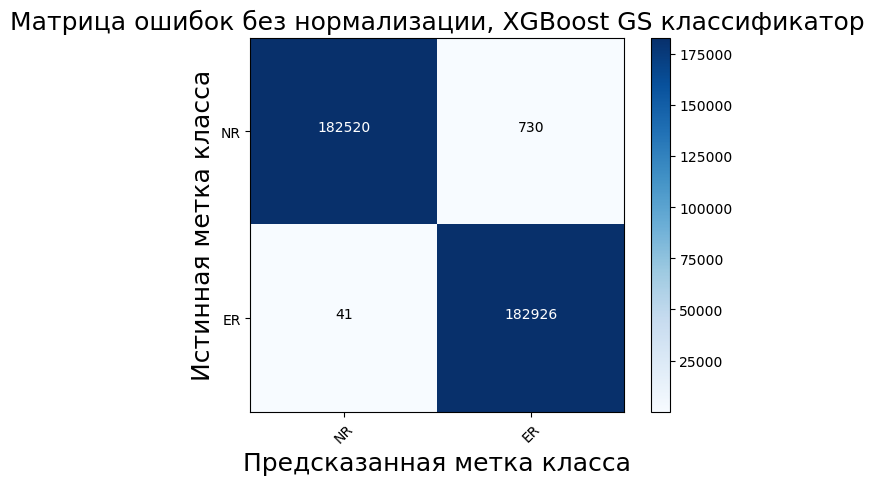

In [31]:
# Plotting confusion matrix after update
# Построение матрицы ошибок после обновления
cnf_matrix_xgb_gs = confusion_matrix(Y_test, xgb_gs_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_xgb_gs,  classes=["NR","ER"],
                      title='Матрица ошибок без нормализации, XGBoost GS классификатор')
plt.title('Матрица ошибок без нормализации, XGBoost GS классификатор', fontsize=18)
plt.xlabel('Предсказанная метка класса',fontsize=18)
plt.ylabel('Истинная метка класса',fontsize=18)

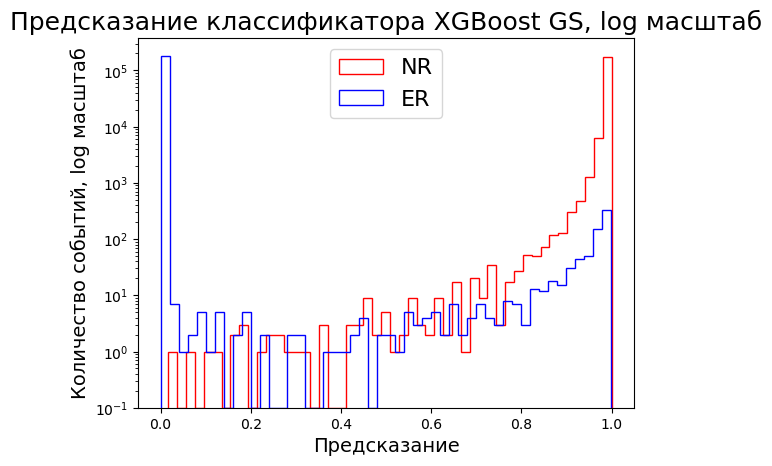

In [30]:
# Plotting predictions of the model after update, log-scale
# Построение предсказания модели после обновления, логарифмический масштаб
idx_NR_xgb = np.where(Y_test == 1)[0]
idx_ER_xgb = np.where(Y_test == 0)[0]
bins = 50
n1_xgb_gs, bins1_xgb_gs, patches1_xgb_gs = plt.hist(predictions_xgb_gs[idx_NR_xgb, 1], log = True, histtype='step', label='NR', bins = bins, color = 'red')
n2_xgb_gs, bins2_xgb_gs, patches2_xgb_gs = plt.hist(predictions_xgb_gs[idx_ER_xgb, 1], log = True, histtype='step', label='ER', bins = bins, color = 'blue')
plt.title('Предсказание классификатора XGBoost GS, log масштаб', fontsize=18)
plt.xlabel('Предсказание',fontsize=14)
plt.ylabel('Количество событий, log масштаб',fontsize=14)
plt.legend(fontsize = 'large', prop={'size': 16}, loc = 'upper center')

### Plotting ROC-curve
### Построение ROC-кривой

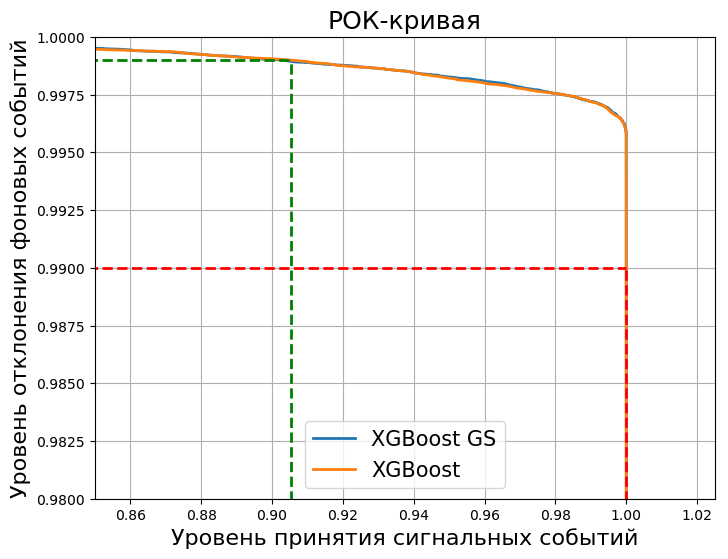

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

plt.plot(tpr_xgb_gs, backrej_xgb_gs,label = 'XGBoost GS', linewidth = 2)
plt.plot(tpr_xgb, backrej_xgb,label = 'XGBoost', linewidth = 2)

x999 = tpr_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.999)))[0][0]]
y999 = backrej_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]
x99 = tpr_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]
y99 = backrej_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]

plt.plot([x99, x99], [0.00, 0.99], color='red', lw=2, linestyle='--')
plt.plot([0, x99], [0.99, 0.99], color='red', lw=2, linestyle='--')
plt.plot([0, x999], [0.999, 0.999], color='green', lw=2, linestyle='--')
plt.plot([x999, x999], [0.00, 0.999], color='green', lw=2, linestyle='--')

plt.xlim(0.85, 1.025)
plt.ylim(0.98, 1.0)
plt.ylabel('Уровень отклонения фоновых событий', fontsize=16)
plt.xlabel('Уровень принятия сигнальных событий', fontsize=16)
plt.title('РОК-кривая', fontsize=18)
plt.legend(loc = "best",fontsize=15)

### Calculation and plotting TP, TN, FP, FN events
### Вычисление и построение TP, TN, FP, FN событий

In [33]:
test_s1 = X_test['s1']
test_f90 = X_test['f90']
TP_s1   = list()
FP_s1   = list()
TN_s1   = list()
FN_s1   = list()
TP_f90   = list()
FP_f90   = list()
TN_f90   = list()
FN_f90   = list()
for l in range (len(xgb_gs_pred)):
    if (xgb_gs_pred[l] == 1 and Y_test[l]==1):
        TP_s1.append(test_s1.iloc[l])
        TP_f90.append(test_f90.iloc[l])
    elif(xgb_gs_pred[l] == 1 and Y_test[l]==0):
        FP_s1.append(test_s1.iloc[l])
        FP_f90.append(test_f90.iloc[l])
    elif(xgb_gs_pred[l] == 0 and Y_test[l]==1):
        FN_s1.append(test_s1.iloc[l])
        FN_f90.append(test_f90.iloc[l])
    elif(xgb_gs_pred[l] == 0 and Y_test[l]==0):
        TN_s1.append(test_s1.iloc[l])
        TN_f90.append(test_f90.iloc[l])    

CPU times: user 7.97 s, sys: 16 ms, total: 7.99 s
Wall time: 7.99 s


Text(0.5, 1.0, 'TN событий: 182520')

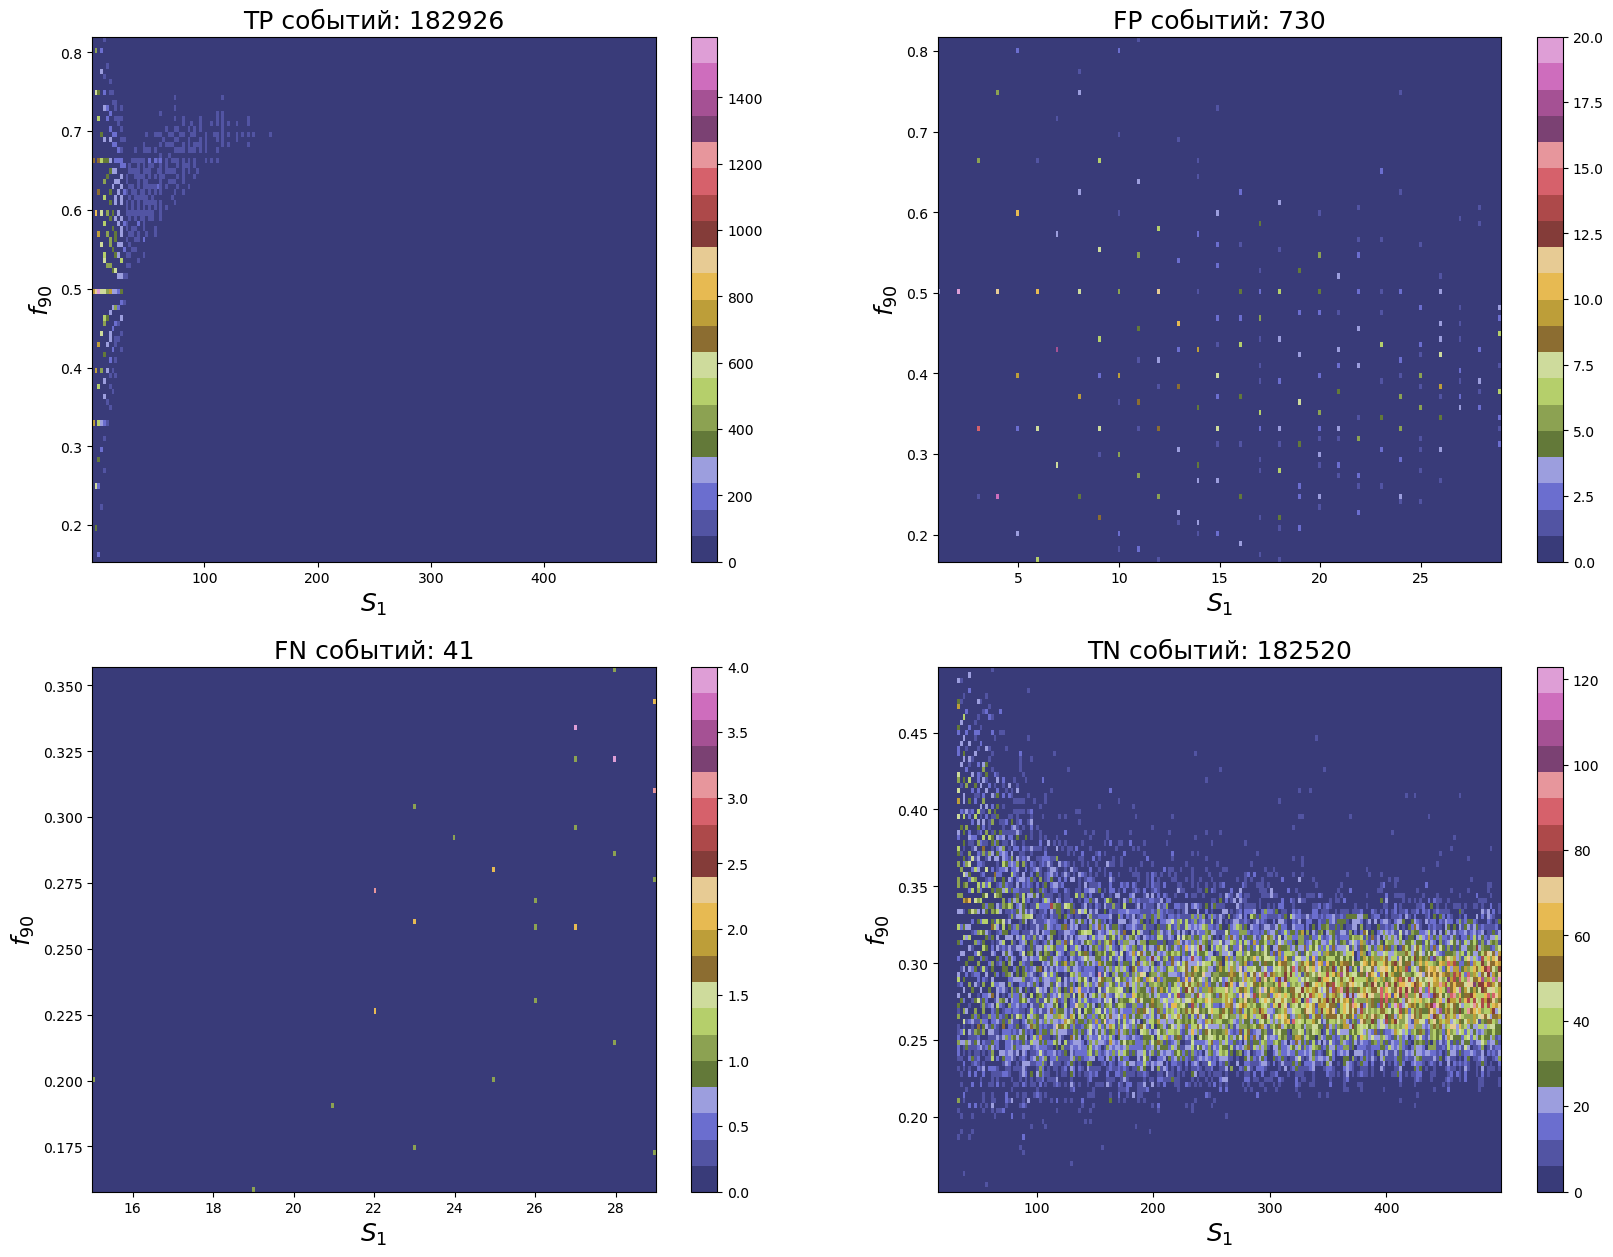

In [34]:
fig1 = plt.figure(figsize=(20,15))
fig.suptitle('TP, FP, FN, TN события для $S_1$ vs. $f_{90}$ на тестовом наборе', fontsize=16)
plt.subplot (2, 2, 1)
plt.hist2d(TP_s1, TP_f90, (200, 100), cmap='tab20b')
plt.colorbar()
plt.ylabel('$f_{90}$', fontsize=18)
plt.xlabel('$S_1$', fontsize=18)
plt.title('TP событий: {0}'.format(len(TP_f90)), fontsize=18)
plt.subplot (2, 2, 2)
plt.hist2d(FP_s1, FP_f90, (200, 100), cmap='tab20b')
plt.colorbar()
plt.ylabel('$f_{90}$', fontsize=18)
plt.xlabel('$S_1$', fontsize=18)
plt.title('FP событий: {0}'.format(len(FP_f90)), fontsize=18)
plt.subplot (2, 2, 3)
plt.hist2d(FN_s1, FN_f90, (200, 100), cmap='tab20b')
plt.colorbar()
plt.ylabel('$f_{90}$', fontsize=18)
plt.xlabel('$S_1$', fontsize=18)
plt.title('FN событий: {0}'.format(len(FN_f90)), fontsize=18)
plt.subplot (2, 2, 4)
plt.hist2d(TN_s1, TN_f90, (200, 100), cmap='tab20b')
plt.colorbar()
plt.ylabel('$f_{90}$', fontsize=18)
plt.xlabel('$S_1$', fontsize=18)
plt.title('TN событий: {0}'.format(len(TN_f90)), fontsize=18)

## MLP classifier
## Модель многослойного перцептрона

In [56]:
# Normalization of train parameters
# Нормализация входных параметров
scaler = StandardScaler()
scaler.fit(X_train.astype(float))
scaler.fit(X_test.astype(float))

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [59]:
# Choosing the model and train it with standart parameters
# Задаем модель и тренируем ее со стандартными параметрами
mlp = MLPClassifier()

mlp.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
# Saving the model
# Сохранение модели
pkl_filename = "mlp_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(mlp, file)

In [61]:
# Calculation of classification report
# Вычисление эффективности классификатора
mlp_pred = mlp.predict(X_test)
print(classification_report(Y_test, mlp_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    183250
           1       1.00      1.00      1.00    182967

    accuracy                           1.00    366217
   macro avg       1.00      1.00      1.00    366217
weighted avg       1.00      1.00      1.00    366217



In [ ]:
# Calculation BRR and SA for ROC-curve
# Вычисление аксептанса сигнала и режекции фона для построения ROC-кривой
predictions_mlp = mlp.predict_proba(X_test)
preds_mlp = predictions_mlp[:,1]
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(Y_test, preds_mlp)
backrej_mlp=np.abs(fpr_mlp-1)

### Graphical analysis
### Графический анализ

Confusion matrix, without normalization
[[182520    730]
 [    46 182921]]


Text(0.5, 13.480591661879602, 'Предсказанная метка класса')

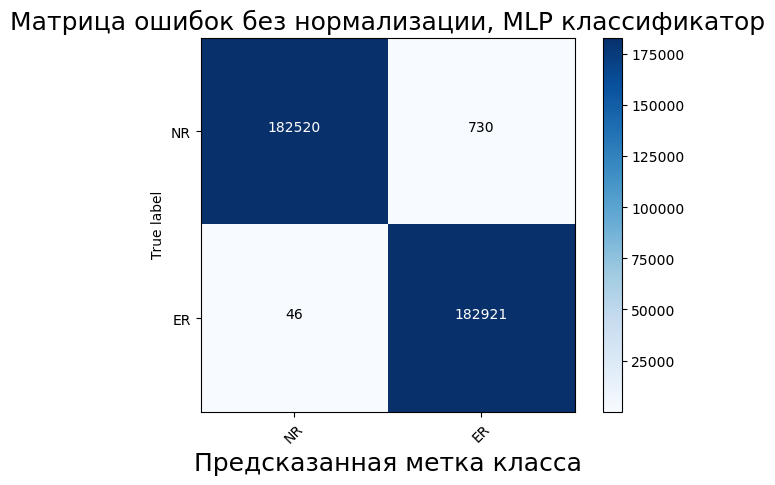

In [43]:
# Plotting confusion matrix
# Построение матрицы ошибок
cnf_matrix_mlp = confusion_matrix(Y_test, mlp_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_mlp,  classes=["NR","ER"],
                      title='Матрица ошибок без нормализации, MLP классификатор')
plt.title('Матрица ошибок без нормализации, MLP классификатор', fontsize=18)
plt.xlabel('Предсказанная метка класса',fontsize=18)

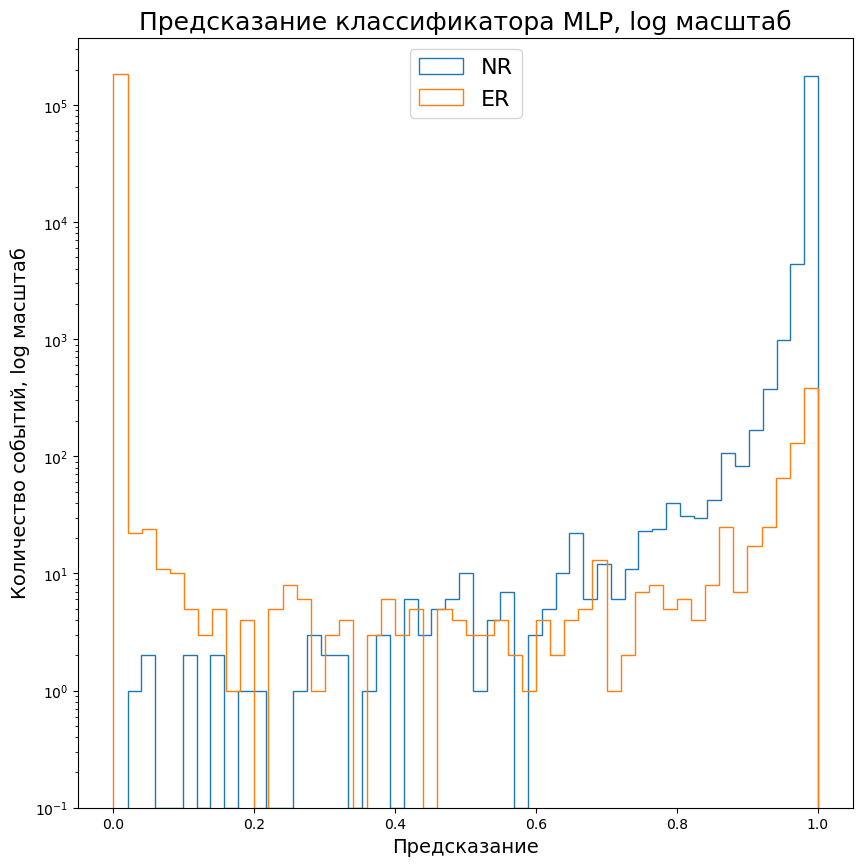

In [45]:
# Plotting predictions of the model, log-scale
# Построение предсказания модели, логарифмический масштаб
idx_NR_mlp = np.where(Y_test == 1)[0]
idx_ER_mlp = np.where(Y_test == 0)[0]
plt.figure(figsize=(10,10))
bins = 50
n1, bins1, patches1 = plt.hist(predictions_mlp[idx_NR_mlp, 1], log = True, histtype='step', label='NR', bins = bins)
n2, bins2, patches2 = plt.hist(predictions_mlp[idx_ER_mlp, 1], log = True, histtype='step', label='ER', bins = bins)
plt.title('Предсказание классификатора MLP, log масштаб', fontsize=18)
plt.xlabel('Предсказание',fontsize=14)
plt.ylabel('Количество событий, log масштаб',fontsize=14)
plt.legend(fontsize = 'large', prop={'size': 16}, loc = 'upper center')

### Randomized Search application
### Оптимизация параметров методом случайного поиска

In [ ]:
# Set grid parameters
# Задаем сетку параметров
param_grid = {
        'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
       'hidden_layer_sizes': [
            (10,10,),(10,10,10,),(11,),(12,),(13,),(14,),(10,15,),(15,),(15,15,)
        ]
   }

In [ ]:
# Output the best parameters of grid
# Выводим наилучшие параметры сетки
gs = RandomizedSearchCV(mlp, param_grid, cv=5, n_iter=100, scoring="roc_auc", n_jobs=-1)  
gs.fit(X_train, Y_train) 
print("Best parameters set found on development set:")
print(gs.best_params_)

In [47]:
# Set and train new model with updated parameters
# Создаем и тренируем новую модель с обновленными параметрами

mlp_rs = MLPClassifier(**gs.best_params_)

mlp_rs.fit(X_train, Y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
# Saving the model after update
# Сохранение модели после обновления
pkl_filename = "mlp_rs_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(mlp_rs, file)

In [50]:
# Calculation of classification report after update
# Вычисление эффективности классификатора после обновления
mlp_rs_pred = mlp_rs.predict(X_test)
print(classification_report(Y_test, mlp_rs_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    183250
           1       1.00      1.00      1.00    182967

    accuracy                           1.00    366217
   macro avg       1.00      1.00      1.00    366217
weighted avg       1.00      1.00      1.00    366217



In [52]:
# Calculation BRR and SA for ROC-curve after update
# Вычисление аксептанса сигнала и режекции фона для построения ROC-кривой после обновления
predictions_mlp_rs = mlp_rs.predict_proba(X_test)
preds_mlp_rs = predictions_mlp_rs[:,1]
fpr_mlp_rs, tpr_mlp_rs, thresholds_mlp_rs = metrics.roc_curve(Y_test, preds_mlp_rs)
backrej_mlp_rs=np.abs(fpr_mlp_rs-1)

### Graphical analysis after update
### Графический анализ после обновления

Confusion matrix, without normalization
[[182506    744]
 [    15 182952]]


Text(0.5, 13.480591661879602, 'Предсказанная метка класса')

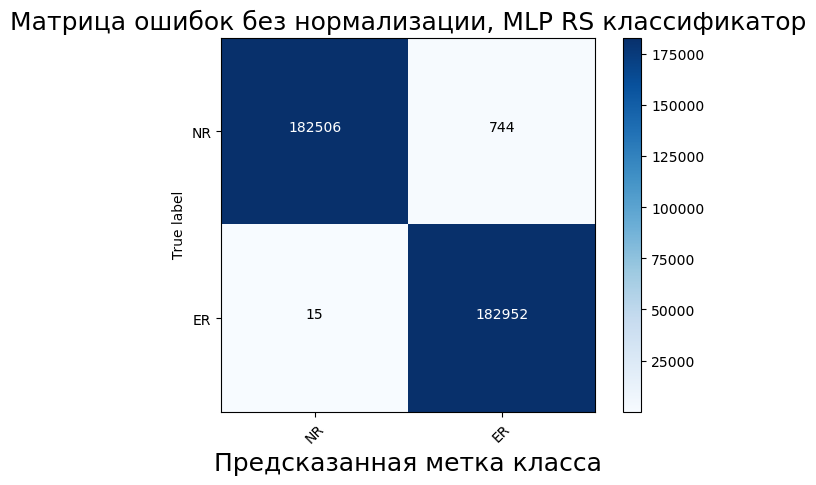

In [51]:
# Plotting confusion matrix after update
# Построение матрицы ошибок после обновления
cnf_matrix_mlp_rs = confusion_matrix(Y_test, mlp_rs_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_mlp_rs,  classes=["NR","ER"],
                      title='Матрица ошибок без нормализации, MLP RS классификатор')
plt.title('Матрица ошибок без нормализации, MLP RS классификатор', fontsize=18)
plt.xlabel('Предсказанная метка класса',fontsize=18)

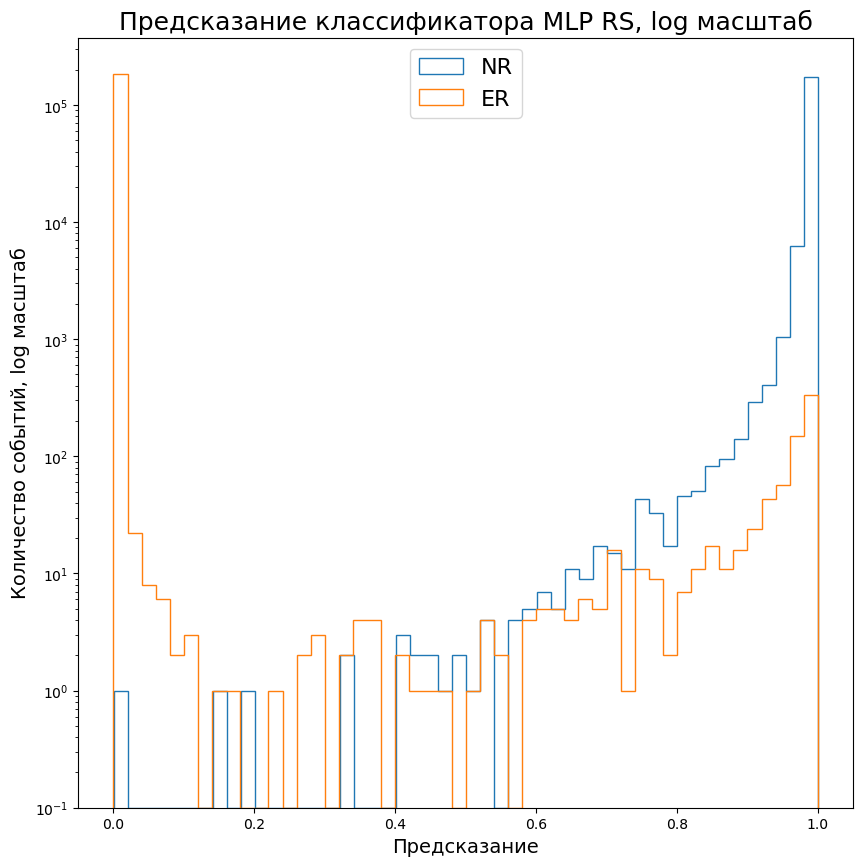

In [53]:
# Plotting predictions of the model after update, log-scale
# Построение предсказания модели после обновления, логарифмический масштаб
idx_NR_mlp = np.where(Y_test == 1)[0]
idx_ER_mlp = np.where(Y_test == 0)[0]
plt.figure(figsize=(10,10))
bins = 50
n1, bins1, patches1 = plt.hist(predictions_mlp_rs[idx_NR_mlp, 1], log = True, histtype='step', label='NR', bins = bins)
n2, bins2, patches2 = plt.hist(predictions_mlp_rs[idx_ER_mlp, 1], log = True, histtype='step', label='ER', bins = bins)
plt.title('Предсказание классификатора MLP RS, log масштаб', fontsize=18)
plt.xlabel('Предсказание',fontsize=14)
plt.ylabel('Количество событий, log масштаб',fontsize=14)
plt.legend(fontsize = 'large', prop={'size': 16}, loc = 'upper center')


Model Report
AUC Score XGBoost    (Test): 0.999751
AUC Score XGBoost GS (Test): 0.999756
AUC Score MLP        (Test): 0.999751
AUC Score MLP RS     (Test): 0.999752


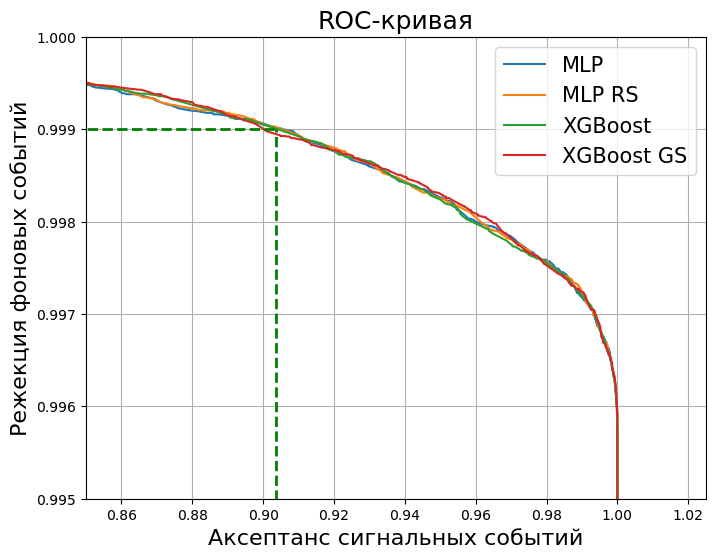

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
x0 = round(tpr_xgb[list(np.where(backrej_xgb<1))[0][0]],2)
x1 = round(tpr_xgb[list(np.where(tpr_xgb<1))[0][-1]],2)
y0 = backrej_xgb[list(np.where(backrej_xgb<1))[0][0]]
y1 = backrej_xgb[list(np.where(tpr_xgb<1))[0][-1]]
new_tpr_xgb = tpr_xgb[list(np.where(backrej_xgb<1))[0][0]:list(np.where(tpr_xgb<1))[0][-1]]
new_backrej_xgb = backrej_xgb[list(np.where(backrej_xgb<1))[0][0]:list(np.where(tpr_xgb<1))[0][-1]]
x999 = tpr_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.999)))[0][0]]
y999 = backrej_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]
x99 = tpr_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]
y99 = backrej_xgb[list(np.where(backrej_xgb == find_nearest(backrej_xgb, 0.99)))[0][0]]
plt.plot(tpr_mlp, backrej_mlp,label = 'MLP')
plt.plot(tpr_mlp_rs, backrej_mlp_rs,label = 'MLP RS')
plt.plot(tpr_xgb, backrej_xgb,label = 'XGBoost')
plt.plot(tpr_xgb_gs, backrej_xgb_gs,label = 'XGBoost GS')

plt.plot([x99, x99], [0.00, 0.99], color='red', lw=2, linestyle='--')
plt.plot([0, x99], [0.99, 0.99], color='red', lw=2, linestyle='--')
plt.plot([0, x999], [0.999, 0.999], color='green', lw=2, linestyle='--')
plt.plot([x999, x999], [0.00, 0.999], color='green', lw=2, linestyle='--')
plt.xlim(0.85, 1.025)
plt.ylim(0.995, 1.0)
plt.ylabel('Режекция фоновых событий', fontsize=16)
plt.xlabel('Аксептанс сигнальных событий', fontsize=16)
plt.title('ROC-кривая', fontsize=18)
plt.legend(loc = "best",fontsize=15)
print ("\nModel Report")
print ("AUC Score XGBoost    (Test): %f" % metrics.roc_auc_score(Y_test, preds_xgb))
print ("AUC Score XGBoost GS (Test): %f" % metrics.roc_auc_score(Y_test, preds_xgb_gs))
print ("AUC Score MLP        (Test): %f" % metrics.roc_auc_score(Y_test, preds_mlp))
print ("AUC Score MLP RS     (Test): %f" % metrics.roc_auc_score(Y_test, preds_mlp_rs))